In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm
import scipy.stats as stats
from sklearn.linear_model import LinearRegression

import os
import pickle

import SAM
import float_data as flt

import importlib
importlib.reload(SAM)
importlib.reload(flt)

from dask import delayed

def moving_average(x, w):
  return np.convolve(x, np.ones(w), 'valid') / w

In [13]:
# Number of classes 
n_classes = 7
model_folder = 'model'
data_folder = 'data'

#IDs to use
ids = ['r1i1p1f2', 'r2i1p1f2', 'r3i1p1f2', 'r4i1p1f2', 'r5i1p1f3', 'r6i1p1f3', 'r7i1p1f3', 'r8i1p1f2', 'r9i1p1f2', 'r10i1p1f2']
f_ids = ['r5i1p1f3', 'r6i1p1f3', 'r7i1p1f3']
#ids = [ids[0]]
mask = np.load('data/mask.npy', allow_pickle=True)

# The filename to use
metric_name = 'areas_prob_high.obj'

In [14]:
# Read the data from file
metric_values = {}
metric_values_mm = {}

# Get the average profiles for the first ensemble, and sort by temperature
path_ref = '{}/{}/{}'.format(model_folder, ids[0], n_classes)
with open('{}/avg.obj'.format(path_ref), 'rb') as file:
  ref_profiles = pickle.load(file)
  file.close()
    
inds = flt.temp_sort(None, ref_profiles, True)
ref_profiles = [ref_profiles[x] for x in inds]

for m_id in ids:

  path_n = '{}/{}/{}'.format(model_folder, m_id, n_classes)
  path_n_data = '{}/{}/{}'.format(data_folder, m_id, n_classes)

  # Load the data for this model
  with open('{}/{}'.format(path_n_data, metric_name), 'rb') as file:
      metric_values[m_id] = pickle.load(file)
      file.close()

  # Corrected for the seasonal cycle
  metric_values_mm[m_id] = SAM.monthly_mean(metric_values[m_id])


  # Get the profiles, so they can be sorted
  with open('{}/avg.obj'.format(path_n), 'rb') as file:
    avg_profiles = pickle.load(file)
    file.close()

  # Line up the profiles to the reference
  inds = flt.match_profiles(ref_profiles, avg_profiles)
  metric_values[m_id] = metric_values[m_id].isel(k=inds)
  metric_values_mm[m_id] = metric_values_mm[m_id].isel(k=inds)
  
  tsM = metric_values[m_id]['time'].values

  metric_values[m_id] = metric_values[m_id].transpose('time', 'k')
  metric_values_mm[m_id] = metric_values_mm[m_id].transpose('time', 'k')
  
  metric_values[m_id] = metric_values[m_id].values
  metric_values_mm[m_id] = metric_values_mm[m_id].values
    

In [4]:

SAM_data = {}
SAM_data_mm = {}

for m_id in ids:

  path_n = '{}/{}/{}'.format(model_folder, m_id, n_classes)
  path_n_data = '{}/{}/{}'.format(data_folder, m_id, n_classes)


  # Get the SAM for each ensemble
  options = {'memberId' : m_id}
  SAM_data[m_id] = SAM.retrieve_SAM(timeRange=slice(np.datetime64('1960-01'), np.datetime64('1994-12')), options=options)
  
  SAM_data_mm[m_id]= SAM.monthly_mean(SAM_data[m_id])
  
  tsS = SAM_data[m_id]['time'].values
  
  SAM_data[m_id] = SAM.BW_filter(SAM_data[m_id], 4, 1/8, 'time', btype='high')
  SAM_data[m_id] = SAM_data[m_id].values
  SAM_data_mm[m_id] = SAM_data_mm[m_id].values
    

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 35 times more chunks
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 35 times more chunks
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 35 times more chunks
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 35 times more chunks
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing with an out-of-order index is generating 35 times more chunks
  return self.array[key]
/srv/conda

Find the correlations between the chosen metric and the SAM, both for the raw and corrected data

In [15]:
Rs = {}
ps = {}
Rs_mm = {}
ps_mm = {}

for m_id in ids:
  s1 = np.size(metric_values[m_id], 0)
  s2 = np.size(SAM_data[m_id], 0)
  tsDelay = np.abs(s2 - s1) # the absolute value should be unnecessary

  # A correlation + significance matrix for each value of time delay
  cor = np.zeros((tsDelay+1, n_classes + 1, n_classes + 1))
  p = np.zeros(np.shape(cor))

  for i in range(tsDelay+1):
    a = np.zeros((s1, n_classes + 1))
    a[:, 1:] = metric_values[m_id]
    a[:, 0] = SAM_data[m_id][s2-i-s1:s2-i]
    (cor[i, :, :], p[i, :, :]) = stats.spearmanr(a, axis=0)
  Rs[m_id] = cor
  ps[m_id] = p


  cor = np.zeros((tsDelay+1, n_classes + 1, n_classes + 1))
  p = np.zeros(np.shape(cor))
  for i in range(tsDelay+1):
    a = np.zeros((s1, n_classes + 1))
    a[:, 1:] = metric_values_mm[m_id]
    a[:, 0] = SAM_data_mm[m_id][s2-i-s1:s2-i]
    (cor[i, :, :], p[i, :, :]) = stats.spearmanr(a, axis=0)
  Rs_mm[m_id] = cor
  ps_mm[m_id] = p

Produce a plot of the metric and the SAM

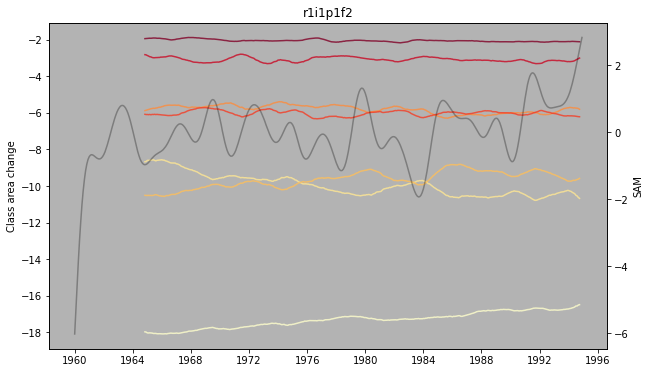

In [94]:
# Filename, if not saving: None
filename = 'mean_lat-plot-BW'
# Width to take a moving average
w = 1
# p value cut-off
p_max = 0.05
# Whether to use raw or corrected data
mm = False
# Delay, either a number of months or 'auto' to delay by the max correlation
delay = 2
# Id to use
m_id = ids[0]

fig, ax = plt.subplots()
cmap = matplotlib.cm.get_cmap('YlOrRd')
axSAM = ax.twinx()

if mm:
  ys = metric_values_mm[m_id]
else:
  ys = metric_values[m_id]
  
axSAM.plot(tsS[w-1:], moving_average(SAM_data[m_id], w), alpha=0.3, c='black')

for k in range(n_classes):
  rgba = list(cmap(k / (n_classes - 1)))
  rgba[-1]=0.8
  ax.plot(tsM[w-1:] - np.timedelta64(delay, 'M').astype('<m8[ns]'), moving_average(ys[:, k], w), c=rgba)

fig.set_size_inches(10, 6)
ax.set_facecolor((0.7, 0.7, 0.7, 1))
ax.set_ylabel('Class area change')
axSAM.set_ylabel('SAM')
ax.set_title(m_id)
if filename is not None:
  plt.savefig('figures/{}'.format(filename), dpi=300)

NameError: name 'delay' is not defined

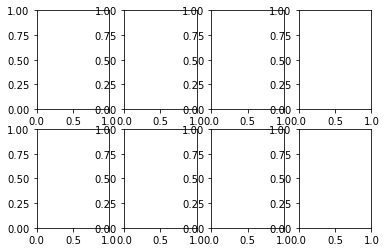

In [12]:
# Options

# Filename, if not saving: None
filename = 'high-mean-lat'
# Width to take a moving average
w = 1
# Whether to use raw or corrected data
mm = False

fig, axes = plt.subplots(2, 4)
axes = axes[0:n_classes]

cmap = matplotlib.cm.get_cmap('YlOrRd')

slopes = np.zeros((n_classes, len(ids)))
slope_ps = np.zeros((n_classes, len(ids)))

for k, ax in zip(range(n_classes), axes.flatten()):
  
  rgba = list(cmap(k / (n_classes - 1)))
  rgba[-1] = 0.2
  
  for (m_i, m_id) in enumerate(ids):

    if mm:
      ys = metric_values_mm[m_id]
    else:
      ys = metric_values[m_id]
    
    slopes[k, m_i], intercept, r_value, slope_ps[k, m_i], std_err = stats.linregress(np.arange(len(ys)),ys[:, k])
    
    if m_id in f_ids:
      ax.plot(tsM[w-1:] - np.timedelta64(delay, 'M').astype('<m8[ns]'), moving_average(ys[:, k], w), c='red')
      continue

    ax.plot(tsM[w-1:] - np.timedelta64(delay, 'M').astype('<m8[ns]'), moving_average(ys[:, k], w), c='black')
    
  ax.set_facecolor(rgba)
  ax.set_title('Class {}'.format(k+1))
  #ax.set_xlabel('Delay / month)
  ax.set_ylabel('Mean / arbitrary units')
  #ax.set_ylim(700, 2900)
    
fig.set_size_inches(20, 10)
if filename is not None:
  plt.savefig('figures/{}'.format(filename), dpi=300)
plt.show()

In [82]:
slopes[6, :]

array([-4.61400046e-04,  7.48283648e-05, -9.93970467e-05, -1.02377198e-04,
       -7.42627729e-04,  4.44860577e-04, -3.59013008e-04, -5.10089577e-05,
       -4.68547869e-05, -2.54424377e-06])

Produce plots of the correlations, for each ensemble

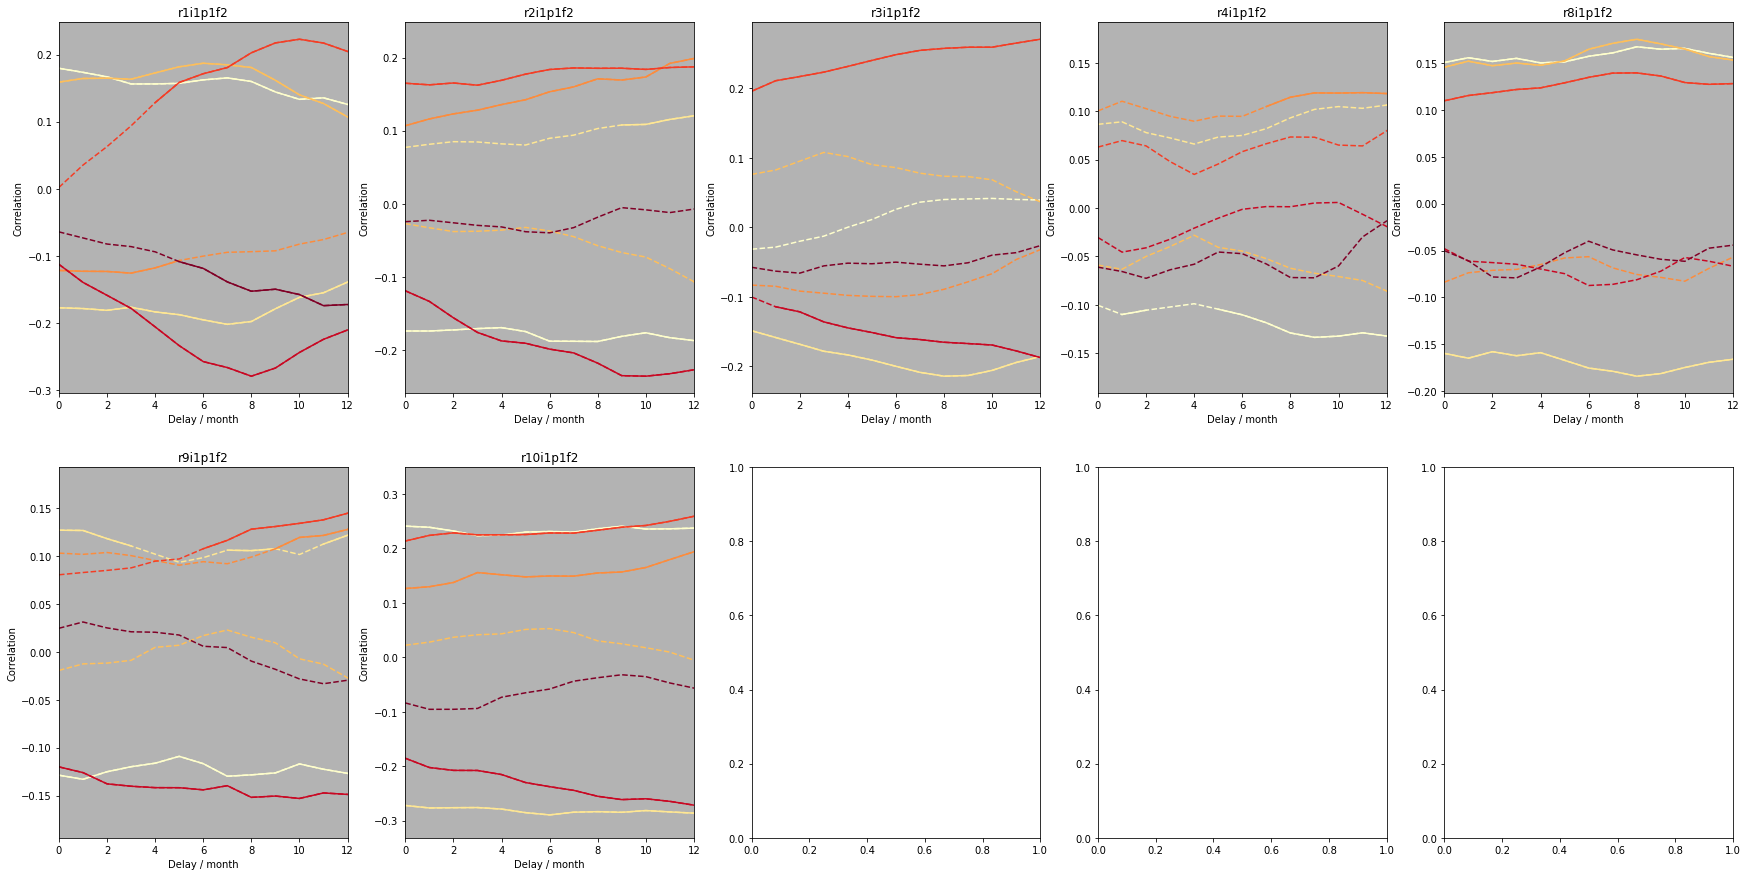

In [11]:
# Options

# Filename, if not saving: None
filename = 'area'
# Width to take a moving average
w = 1
# Plot xlim, in months
xlim = (0, 12)
# p value cut-off
p_max = 0.05
# Whether to use raw or corrected data
mm = False
# Whether to use R2 or R
squared = False


fig, axes = plt.subplots(2, 5)
#axes = np.array(axes)
cmap = matplotlib.cm.get_cmap('YlOrRd')


for m_id, ax in zip(ids, axes.flatten()):
    
  # Get the correlation of the SAM with each of the classes
  if mm:
    cor = Rs_mm[m_id][:, 0, 1:]
    p = ps_mm[m_id][:, 0, 1:]
  else:
    cor = Rs[m_id][:, 0, 1:]
    p = ps[m_id][:, 0, 1:]
    
  if squared:
    cor = cor * cor
  for k in range(n_classes):
    rgba = list(cmap(k / (n_classes - 1)))
    ys = moving_average(cor[:, k], w)
    p_k = moving_average(p[:, k], w)

    ax.plot(np.where(p_k < p_max, ys, np.nan), c=rgba)
    ax.plot(ys, c=rgba, ls='--')



  ax.set_facecolor((0.7, 0.7, 0.7, 1))
  ax.set_title(m_id)
  ax.set_xlabel('Delay / month')
  ax.set_ylabel('Correlation')
  ax.set_xlim(xlim[0], xlim[1])
    
fig.set_size_inches(30, 15)
if filename is not None:
  plt.savefig('figures/{}'.format(filename), dpi=300)
plt.show()

Produce plots of the correlations, for each class

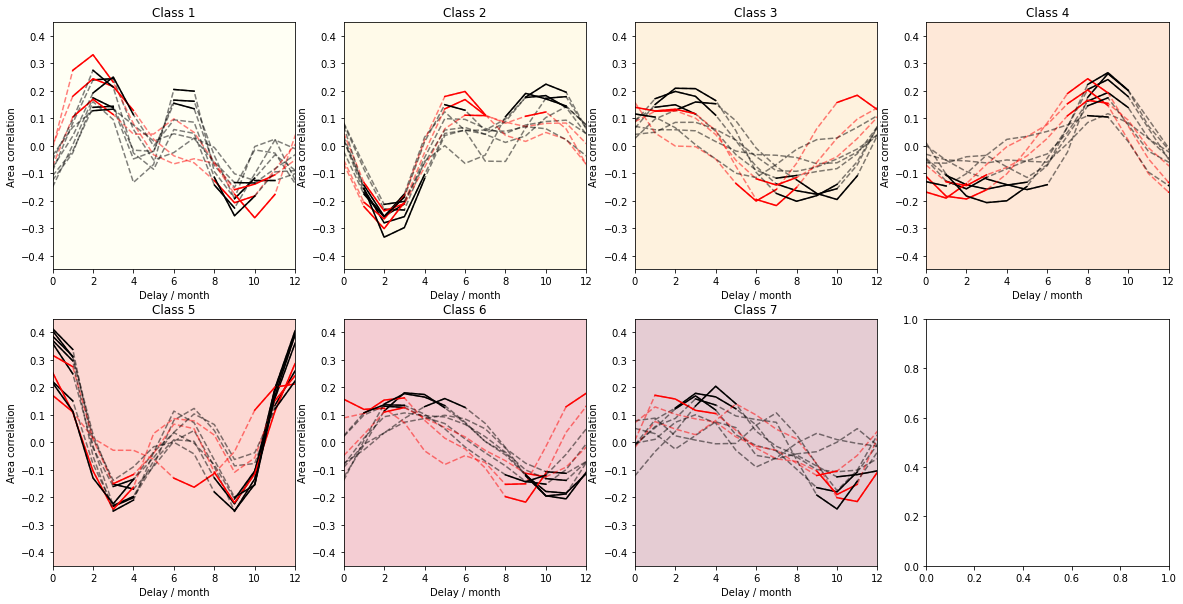

In [17]:
# Options

# Filename, if not saving: None
filename = 'area-corr-high'
# Width to take a moving average
w = 1
# Plot xlim, in months
xlim = (0, 12)
# p value cut-off
p_max = 0.05
# Whether to use raw or corrected data
mm = False
# Whether to plot R2 or R
squared = False

fig, axes = plt.subplots(2, 4)
axes = axes[0:n_classes]

cmap = matplotlib.cm.get_cmap('YlOrRd')

for k, ax in zip(range(n_classes), axes.flatten()):
  
  rgba = list(cmap(k / (n_classes - 1)))
  rgba[-1] = 0.2
  
  for m_id in ids:

    # Get the correlation with the SAM
    if mm:
      cor = Rs_mm[m_id][:, 0, k+1]
      p = ps_mm[m_id][:, 0, k+1]
    else:
      cor = Rs[m_id][:, 0, k+1]
      p = ps[m_id][:, 0, k+1]
      
    if squared:
      cor = cor * cor

    ys = moving_average(cor, w)
    p_k = moving_average(p, w)
    
    if m_id in f_ids:
      ax.plot(np.where(p_k < p_max, ys, np.nan), c='red')
      ax.plot(ys, c=(1, 0, 0, 0.5),  ls='--')
      continue

    ax.plot(np.where(p_k < p_max, ys, np.nan), c='black')
    ax.plot(ys, c=(0, 0, 0, 0.5),  ls='--')
    
  ax.set_facecolor(rgba)
  ax.set_title('Class {}'.format(k+1))
  ax.set_xlabel('Delay / month')
  ax.set_ylabel('Area correlation')
  ax.set_xlim(xlim[0], xlim[1])
  if squared:
    ax.set_ylim(0, 0.16)
  else:
    ax.set_ylim(-0.45, 0.45)
    
fig.set_size_inches(20, 10)
if filename is not None:
  plt.savefig('figures/{}'.format(filename), dpi=300)
plt.show()

In [19]:
ids

['r1i1p1f2',
 'r2i1p1f2',
 'r3i1p1f2',
 'r4i1p1f2',
 'r8i1p1f2',
 'r9i1p1f2',
 'r10i1p1f2']

0.12167838482705762
[140946.93876222 142932.83006603 132387.0874258  120194.78749429
  34947.32468447  74286.09478062  14560.44976503]
0.25044372286499106
[-120901.86712003 -172056.18382396 -154767.64963563 -178315.3935589
  -46250.89813961  -89997.95001024  -12704.51061953]
0.15857969713613163
[106737.92630257 152482.10430424 155850.47542212 162358.02692399
  45971.07332251  83039.75630078  16799.15192325]
0.12598446031931398
[ 83589.00755583 131495.48440335 141297.38492226 118547.5954185
  27951.64710042  66774.61314239  18573.03878108]
0.1543041778745331
[-59671.44539542 -95609.00101314 -92334.08320979 -87736.59525881
 -17090.76987014 -51424.08340323 -14451.51911866]
0.10006202524536201
[41086.92797124 70778.65430681 72016.48458275 64221.9934005
 16491.55058831 26856.63543149  6318.20582023]
0.20183641506681438
[126789.12103923 168840.59988696 167407.6778994  187229.15881905
  29803.23460131 118290.74292614  39269.55541431]
0.18655883619350577
[30698.58205979 49683.83185729 40812.98

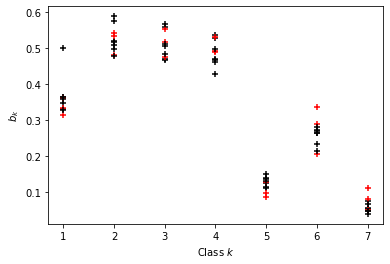

In [31]:
## Options

# Filename, if not saving: None
filename = 'linreg-mean-lat-high'
# Width to take a moving average
w = 1
# Plot xlim, in months
xlim = (0, 36)
# p value cut-off
p_max = 0.05
# Whether to use raw or corrected data
mm = False
# Delay, either a number of months or 'auto' to delay by the max correlation
delay = 2
# Id to use


for m_id in ids:
  if mm:
    a = metric_values_mm[m_id]
    
    n = np.size(a, 0)
    K = np.size(a, 1)
    
    xs = np.zeros((n-w+1, K))
    
    for i in range(K):
      xs[:, i] = moving_average(a[:, i], w)
    ys = moving_average(SAM_data_mm[m_id][-n-delay:-delay], w)
  else:
    a = metric_values[m_id]
    
    n = np.size(a, 0)
    K = np.size(a, 1)
    
    xs = np.zeros((n-w+1, K))
    
    for i in range(K):
      xs[:, i] = moving_average(a[:, i], w)
    ys = moving_average(SAM_data[m_id][-n-delay:-delay], w)


  xs = (xs - np.mean(xs, 0)) / np.std(xs, 0)
  ys = (ys - np.mean(ys, 0)) / np.std(ys, 0)
  lm = LinearRegression()
  lm.fit(xs, ys)
  print(lm.score(xs, ys))
  a = lm.coef_
  print(a)
  a = np.sign(a[0]) * a
  a = a / np.sqrt(np.sum(a * a))
  if m_id in f_ids:
    plt.scatter(np.arange(7)+1,a, color='red', marker='+')
  else:
    plt.scatter(np.arange(7)+1,a, color='black', marker='+')
    
plt.xlabel('Class $k$')
plt.ylabel('$b_k$')
if filename is not None:
  plt.savefig('figures/{}'.format(filename), dpi=300)

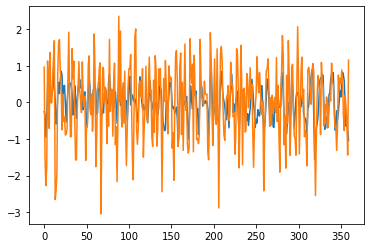

In [25]:
fig, ax = plt.subplots()
ax.plot(lm.predict(xs))
ax.plot(ys)